In [1]:
!pip install -U "finetuner[full]" # finetuner-full will install ML libraries such as torchvision and transformers

!pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 658.0/658.0 kB 23.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 kB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.5/113.5 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 69.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 85.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 66.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 76.6 MB/s 

In [2]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip uninstall typing-extensions
!pip install typing-extensions==4.5.0

Found existing installation: typing_extensions 4.5.0
Uninstalling typing_extensions-4.5.0:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/typing_extensions-4.5.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/typing_extensions.py
Proceed (Y/n)? Y
  Successfully uninstalled typing_extensions-4.5.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached typing_extensions-4.5.0-py3-none-any.whl (27 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.0.2+cu118 requires torch==2.0.1, but you have torch 1.12.1 which is incompatible.
torchdata 0.6.1 requires torch==2.0.1, but you have torch 1.12.1 which is incompatible.
torchtext 0.15.2 requires torch==2.0.1, but you have torch 1.12.1 which is incompatible.


In [4]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sleepingcat4","key":"1635d150240f0747baaf21522c8dfaf5"}'}

In [5]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/


In [6]:
!chmod 600 ~/.kaggle/kaggle.json


In [7]:
!kaggle datasets download -d just1ce5/genshin-impact-characters-dataset

 88% 35.0M/39.8M [00:00<00:00, 62.9MB/s]
100% 39.8M/39.8M [00:00<00:00, 59.6MB/s]


In [9]:
!unzip genshin-impact-characters-dataset.zip

Archive:  genshin-impact-characters-dataset.zip
  inflating: dataset/Albedo/1.jpg    
  inflating: dataset/Albedo/10.jpg   
  inflating: dataset/Albedo/100.jpg  
  inflating: dataset/Albedo/11.jpg   
  inflating: dataset/Albedo/12.jpg   
  inflating: dataset/Albedo/13.jpg   
  inflating: dataset/Albedo/14.jpg   
  inflating: dataset/Albedo/15.jpg   
  inflating: dataset/Albedo/16.jpg   
  inflating: dataset/Albedo/17.jpg   
  inflating: dataset/Albedo/18.jpg   
  inflating: dataset/Albedo/19.jpg   
  inflating: dataset/Albedo/2.jpg    
  inflating: dataset/Albedo/20.jpg   
  inflating: dataset/Albedo/21.jpg   
  inflating: dataset/Albedo/22.jpg   
  inflating: dataset/Albedo/23.jpg   
  inflating: dataset/Albedo/24.jpg   
  inflating: dataset/Albedo/25.jpg   
  inflating: dataset/Albedo/26.jpg   
  inflating: dataset/Albedo/27.jpg   
  inflating: dataset/Albedo/28.jpg   
  inflating: dataset/Albedo/29.jpg   
  inflating: dataset/Albedo/3.jpg    
  inflating: dataset/Albedo/30.jpg   
  

In [10]:
from docarray import Document, DocumentArray

da = DocumentArray.from_files('/content/dataset/*/*.*')

def assign_labels(d: Document):
    d.tags['finetuner_label'] = d.uri.split('/')[3]
    return d

da.apply(assign_labels, show_progress=True)
# shuffle and train-test-split to 50-50
da = da.shuffle()
train_da = da[:250]
test_da = da[250:]

Output()

In [11]:
import torch
import clip
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

def preprocess_and_encode_image(d: Document):
    """Preprocess image and extract embeddings from CLIP image encoder"""
    d.tensor = preprocess(Image.open(d.uri)).unsqueeze(0).to(device)
    d.embedding = model.encode_image(d.tensor).cpu().detach().numpy().squeeze()
    d.pop('tensor')
    return d

def preprocess_and_encode_text(d: Document):
    """Preprocess image and extract embeddings from CLIP text encoder"""
    d.tensor = clip.tokenize(d.text).to(device)
    d.embedding = model.encode_text(d.tensor).cpu().detach().numpy().squeeze()
    d.pop('tensor')
    return d

100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 66.4MiB/s]


In [12]:
# embed all test documents
test_da.apply(preprocess_and_encode_image, show_progress=True)

Output()

╭──────────────────────────── Documents Summary ─────────────────────────────╮
│                                                                            │
│   Type                   DocumentArrayInMemory                             │
│   Length                 250                                               │
│   Homogenous Documents   True                                              │
│   Common Attributes      ('id', 'mime_type', 'uri', 'tags', 'embedding')   │
│   Multimodal dataclass   False                                             │
│                                                                            │
╰────────────────────────────────────────────────────────────────────────────╯
╭────────────────────── Attributes Summary ───────────────────────╮
│                                                                 │
│   Attribute   Data type      #Unique values   Has empty value   │
│  ─────────────────────────────────────────────────────────────  │
│   embedding   ('ndarray',)   250              False             │
│   id          ('str',)       250              False             │
│   mime_type   ('str',)       1                False             │
│   tags        ('dict',)      250              False             │
│   uri         ('str',)       250              False             │
│                                                                 │
╰─────────────────────────────────────────────────────────────────╯

The matched document agains query Albedo being cute at position 0 is Hu Tao


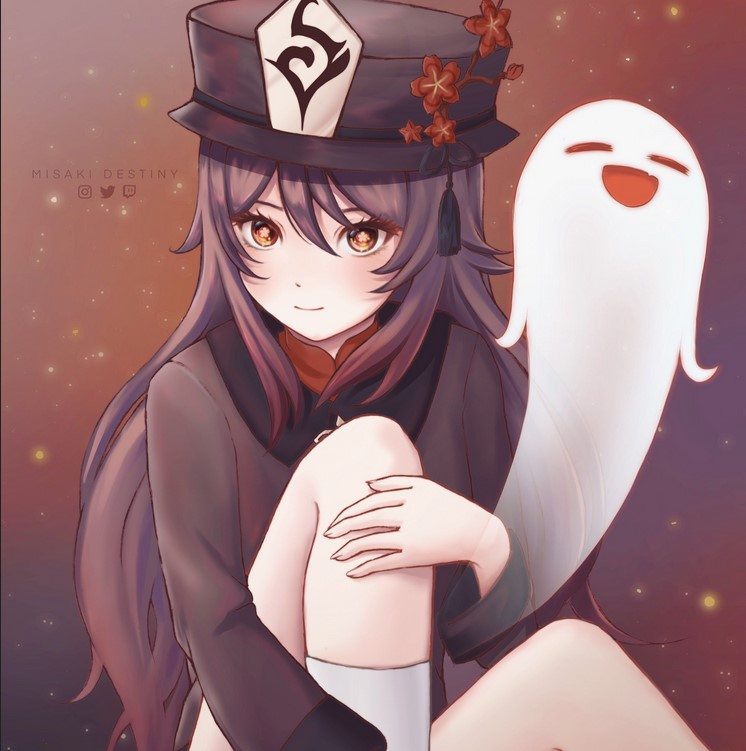

The matched document agains query Albedo being cute at position 1 is Neither


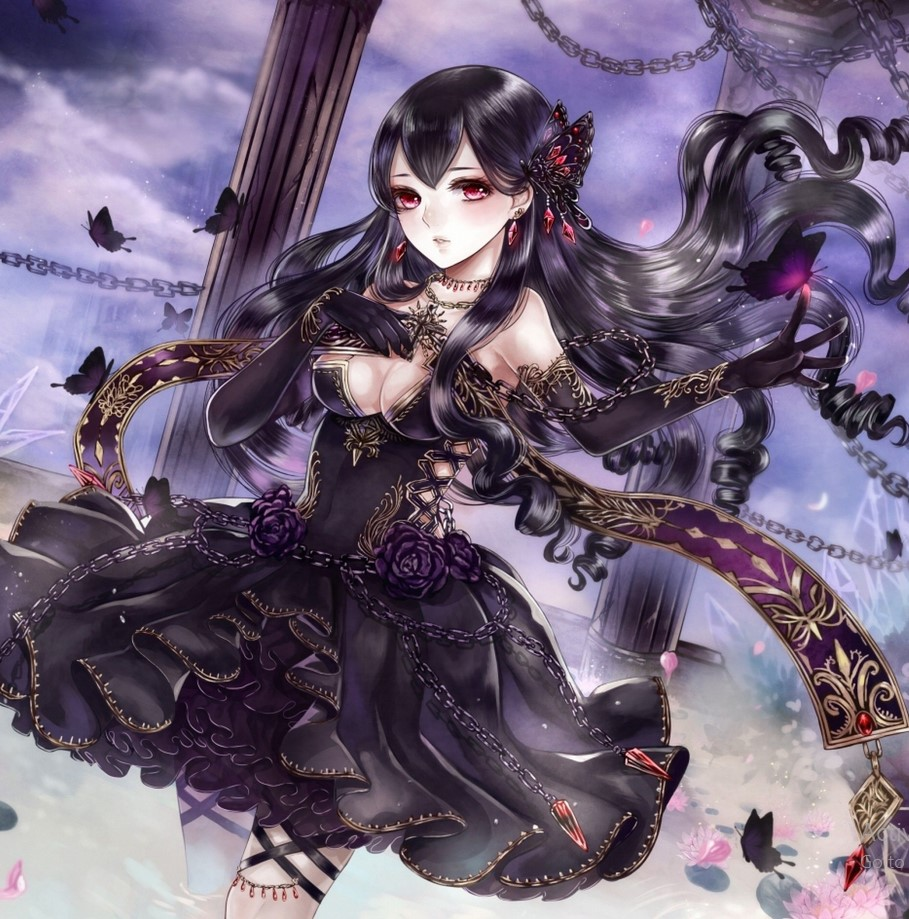

The matched document agains query Albedo being cute at position 2 is Hu Tao


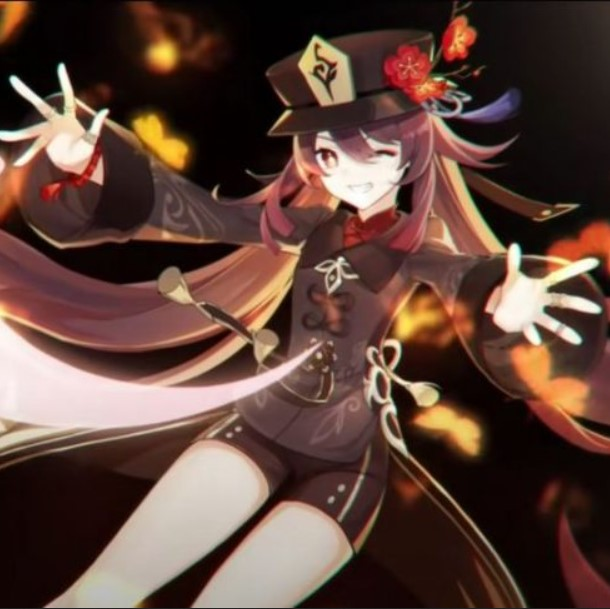

The matched document agains query Albedo being cute at position 3 is Hu Tao


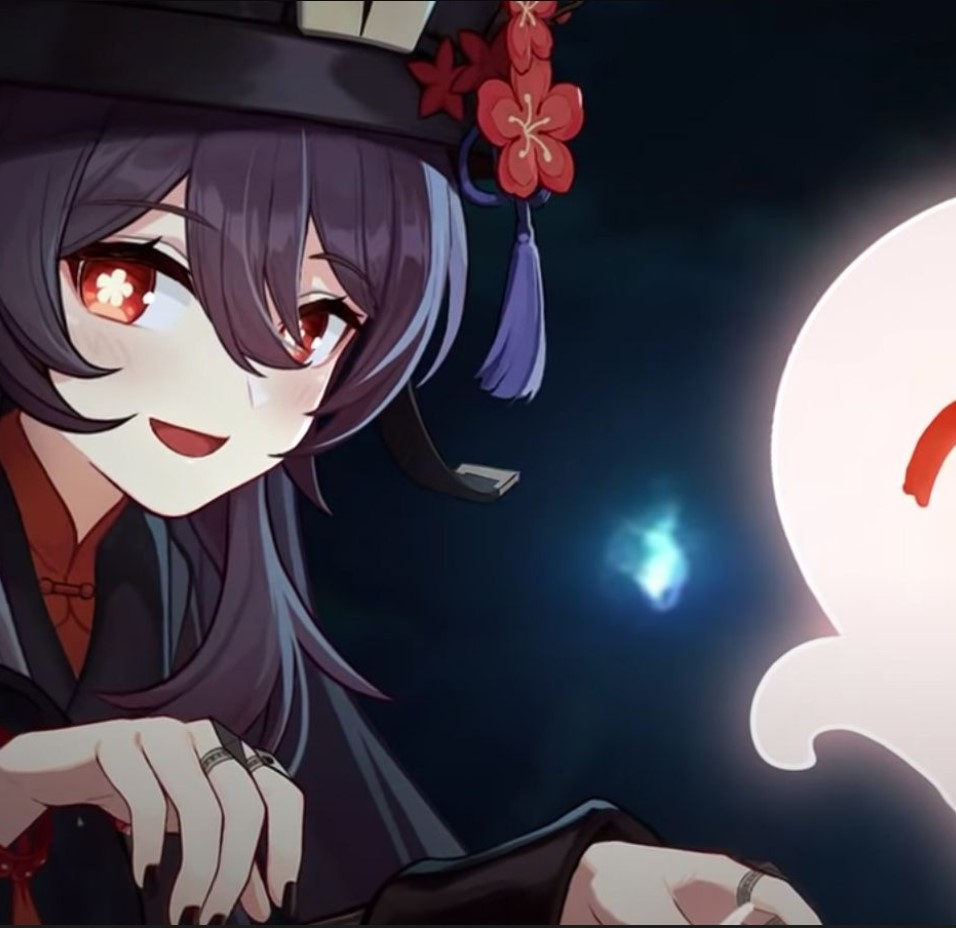

The matched document agains query Albedo being cute at position 4 is Neither


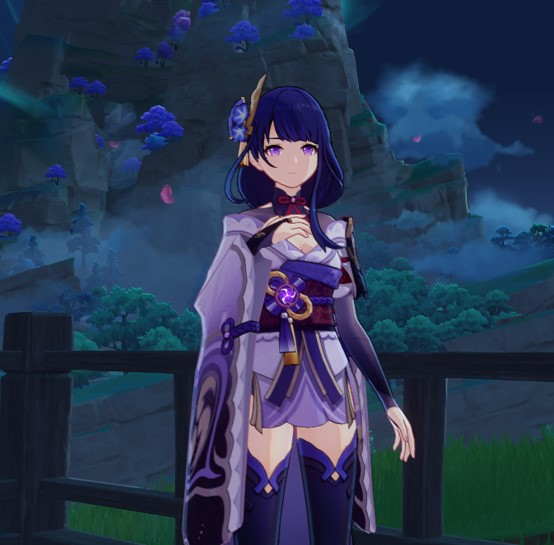

In [14]:
# embed a user query
query = 'Albedo being cute'
query_docs = DocumentArray([Document(content=query)])
query_docs.apply(preprocess_and_encode_text)
# find top 5 matches
query_docs.match(test_da, metric='cosine', limit=5)
# plot matches
for idx, match in enumerate(query_docs[0].matches):
    print(f'The matched document agains query \033[1m{query}\033[0m at position \033[1m{idx}\033[0m is \033[1m{match.tags["finetuner_label"]}\033[0m')
    match.display()